<a href="https://colab.research.google.com/github/raulbenitez/AMRITA_UPC/blob/main/generate_blobs_properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Generate blobs database

In [82]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd




L = 256 
N = 50 # number of images

I = np.zeros((L,L,N))
v = np.zeros(N)
for k in range(N):
  I_aux = data.binary_blobs(length=L, blob_size_fraction=0.1,volume_fraction=0.3)
  I[:,:,k] = I_aux
  label_image, nregions = measure.label(I[:,:,k],return_num=True)

  props_aux = measure.regionprops_table(label_image,properties=['label','area','eccentricity','extent'])

  if k == 0:
    df = pd.DataFrame(props_aux)
  else: 
    df = df.append(pd.DataFrame(props_aux), ignore_index=True)

  df_aux = pd.DataFrame(props_aux)
  a_max = max(df_aux['area'].values)

# label images with a blob with area larger than 4000 as abnormal type (class label = 1)
  if a_max > 4000:
    v[k] = 1

  print('Image number {}, number of regions {}, area of largest region {}, class {}'.format(k,nregions,a_max,v[k]))

Image number 0, number of regions 31, area of largest region 2242, class 0.0
Image number 1, number of regions 31, area of largest region 4089, class 1.0
Image number 2, number of regions 34, area of largest region 3136, class 0.0
Image number 3, number of regions 29, area of largest region 2140, class 0.0
Image number 4, number of regions 25, area of largest region 5527, class 1.0
Image number 5, number of regions 32, area of largest region 3316, class 0.0
Image number 6, number of regions 27, area of largest region 6554, class 1.0
Image number 7, number of regions 23, area of largest region 5680, class 1.0
Image number 8, number of regions 31, area of largest region 2079, class 0.0
Image number 9, number of regions 31, area of largest region 3631, class 0.0
Image number 10, number of regions 31, area of largest region 3189, class 0.0
Image number 11, number of regions 31, area of largest region 2885, class 0.0
Image number 12, number of regions 28, area of largest region 4820, class 

In [81]:
v.shape

(50,)

Visualize the features:

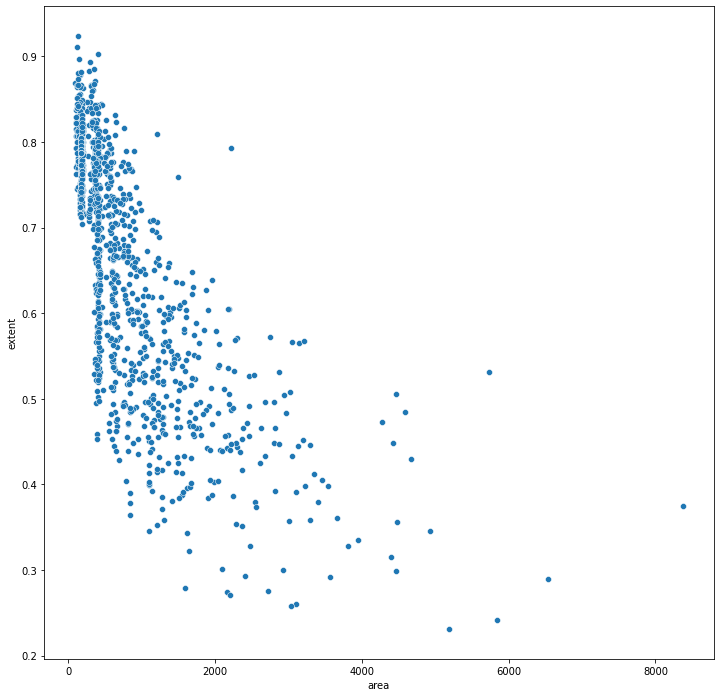

In [68]:
import seaborn as sns

fig = plt.figure(figsize=(12,12))

sns.scatterplot(x='area',y='extent',data=df)

Label image as pathological if it contains an object with an area larger than 4000